In [2]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoModelForMaskedLM

from utils import *
from dataset import *
from preprocess import *
from wrapper import *
from models import *
from pipeline import PipelineGED

np.random.seed(1024)

# device = torch.device("cpu")
device = torch.device("cuda:0")
ntf()

In [4]:
MODEL_SIZE = 'base'
MODEL_ARCH = 'macbert+bert-wwm'



np.random.seed(297)

train_df = pd.read_csv('../data/data-org/train.csv', sep='\t', index_col='id') #.iloc[np.random.choice(range(45000), size=500)]
test_df = pd.read_csv('../data/data-org/test.csv', sep='\t', index_col='id')

oob_model_name = None
if MODEL_ARCH == 'ernie':
    model_name = 'nghuyong/ernie-gram-zh'
elif MODEL_ARCH == 'macbert':
    model_name = 'hfl/chinese-macbert-base' if MODEL_SIZE == 'base' else 'hfl/chinese-macbert-large'
elif MODEL_ARCH == 'roberta-word-based':
    model_name = 'uer/roberta-base-word-chinese-cluecorpussmall'
elif MODEL_ARCH == 'macbert+bert-wwm':
    model_name = 'hfl/chinese-macbert-base'
    oob_model_name = 'KoichiYasuoka/chinese-bert-wwm-ext-upos'
else:
    raise NotImplementedError(f'Model {MODEL_ARCH} is not implemented yet.')



max_length = 64

test_dataset_config = {
    'model_name':model_name,
    'aux_model_name':oob_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':False, 
    'cut_all':False, 
}

test = DatasetWithAuxiliaryEmbeddings(df=test_df.reset_index(), **test_dataset_config)
test.tokenize()
test.construct_dataset()

train_dataset_config = {
    'model_name':model_name,
    'aux_model_name':oob_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':False, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':False, 
    'cut_all':False, 
}

train = DatasetWithAuxiliaryEmbeddings(df=train_df.reset_index(), **train_dataset_config)
train.tokenize()
train.construct_dataset()

ntf()

In [5]:
if MODEL_ARCH == 'macbert':
    checkpoints = [
        '../finetuned_models/ensemble/model0/checkpoint-2400/pytorch_model.bin',
    ]
elif MODEL_ARCH == 'ernie':
    checkpoints = [f'../finetuned_models/balanced_trial_ernie_gram/fold{i}/checkpoint-1910/pytorch_model.bin' for i in range(10)] 
elif MODEL_ARCH == 'roberta-word-based':
    checkpoints = [
        "../finetuned_models/word-based-roberta/model0/checkpoint-1500/pytorch_model.bin", 
        # "../finetuned_models/word-based-roberta/model1/checkpoint-1000/pytorch_model.bin", 
        # "../finetuned_models/word-based-roberta/model2/checkpoint-1500/pytorch_model.bin", 
        # "../finetuned_models/word-based-roberta/model3/checkpoint-2000/pytorch_model.bin", 
        # "../finetuned_models/word-based-roberta/model4/checkpoint-500/pytorch_model.bin", 
    ]
elif MODEL_ARCH == 'macbert+bert-wwm':
    checkpoints = [
        "../finetuned_models/macbert_with_wwm_upos/model0/checkpoint-2706/pytorch_model.bin", 
    ]
else:
    print(f'Model {MODEL_ARCH} is not implemented yet.')

data_configs = {
    'model_name':model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'split_words':False, 
    'cut_all':False, 
}
clf = PipelineGED(
    model_name=model_name, 
    data_configs=data_configs, 
    pooling_mode='cls',  
    model_architecture='bert_with_oob', 
)

def apply_ged_pipeline_oob(texts, majority_vote=False):
    probs = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False)
    return probs

def apply_ged_pipeline(texts, majority_vote=False):
    if majority_vote:
        return clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False, majority_vote=True)
    probs, seq_probs, err_char_lst = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False, majority_vote=False)
    return probs, seq_probs, err_char_lst

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Eval on train set

In [5]:
probs, seq_probs, err_char_lst = apply_ged_pipeline(train_df.text.values[:1000])
prediction = probs.argmax(1)
ntf()

100%|██████████| 63/63 [00:52<00:00,  1.19it/s]


In [6]:
data = train_df[['label', 'text']][:1000]
data['prediction'] = prediction
data['score'] = probs[:, 1]
data['confidence'] = 1 - 2*np.abs(data.score.values - data.prediction)
data = data[['label', 'prediction', 'score', 'confidence', 'text']]
data['err_chars'] = err_char_lst
print(len(data[data.label != data.prediction]))

with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

192


label  prediction     score  confidence  \
id                                              
4         1           0  0.363363    0.273274   
9         1           0  0.478366    0.043268   
20        1           0  0.452915    0.094170   
21        0           1  0.725179    0.450358   
48        1           0  0.249672    0.500655   
56        1           0  0.300548    0.398904   
58        1           0  0.343361    0.313279   
59        1           0  0.165474    0.669051   
68        1           0  0.411026    0.177948   
71        1           0  0.425499    0.149002   
76        0           1  0.908581    0.817162   
82        1           0  0.457035    0.085931   
87        0           1  0.530626    0.061252   
98        1           0  0.453989    0.092023   
101       0           1  0.575827    0.151654   
106       0           1  0.616928    0.233856   
109       1           0  0.338774    0.322452   
121       1           0  0.476771    0.046458   
127       1           0  0.466092    0.067815   
131       1           0  0.375531    0.248939   
133       1           0  0.379437    0.241126   
134       0           1  0.610501    0.221002   
135       1           0  0.164381    0.671237   
141       1           0  0.447164    0.105671   
143       1           0  0.252454    0.495091   
144       0           1  0.928965    0.857929   
145       0           1  0.577865    0.155730   
151       1           0  0.467647    0.064707   
155       1           0  0.305385    0.389231   
157       0           1  0.834963    0.669927   
163       1           0  0.381076    0.237848   
175       1           0  0.249538    0.500924   
184       0           1  0.545459    0.090918   
190       1           0  0.227296    0.545407   
198       1           0  0.444064    0.111872   
213       1           0  0.119913    0.760174   
218       1           0  0.347590    0.304820   
219       1           0  0.228864    0.542272   
221       0           1  0.621307    0.242614   
226       1           0  0.422969    0.154062   
240       1           0  0.491039    0.017923   
241       1           0  0.106399    0.787203   
243       1           0  0.121792    0.756417   
248       1           0  0.271502    0.456995   
256       1           0  0.463521    0.072958   
257       1           0  0.178797    0.642406   
260       0           1  0.780620    0.561241   
273       1           0  0.261561    0.476877   
276       1           0  0.431278    0.137445   
280       1           0  0.325118    0.349763   
282       0           1  0.695896    0.391793   
289       1           0  0.414725    0.170550   
294       1           0  0.378508    0.242984   
299       1           0  0.319707    0.360587   
301       1           0  0.335949    0.328102   
314       1           0  0.433937    0.132127   
316       0           1  0.675693    0.351385   
318       0           1  0.862350    0.724700   
322       1           0  0.369834    0.260332   
332       1           0  0.499914    0.000172   
333       1           0  0.294783    0.410433   
334       1           0  0.366566    0.266868   
336       1           0  0.444663    0.110675   
337       0           1  0.907014    0.814028   
346       0           1  0.825141    0.650281   
354       1           0  0.173984    0.652033   
358       1           0  0.453856    0.092288   
363       0           1  0.558968    0.117937   
375       0           1  0.589288    0.178575   
378       1           0  0.240702    0.518596   
381       1           0  0.168167    0.663665   
391       1           0  0.270958    0.458084   
396       1           0  0.317610    0.364780   
397       1           0  0.466603    0.066795   
399       0           1  0.521863    0.043726   
401       1           0  0.243814    0.512372   
402       1           0  0.320171    0.359658   
405       1           0  0.468233    0.063534   
408       1           0  0.177859    0.644282   
409       1           0  0.224156    

In [59]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 200
    display(data)

label  prediction     score  confidence  \
id                                              
1         1           1  0.974881    0.949762   
2         1           1  0.894500    0.789000   
3         1           1  0.935282    0.870564   
4         1           1  0.871947    0.743894   
5         1           1  0.981274    0.962547   
6         1           1  0.956615    0.913230   
7         0           1  0.820148    0.640296   
8         1           1  0.871957    0.743914   
9         1           1  0.816195    0.632390   
10        1           1  0.918418    0.836836   
11        0           1  0.804086    0.608172   
12        1           1  0.909879    0.819757   
13        1           1  0.916725    0.833449   
14        0           1  0.847558    0.695116   
15        0           1  0.825924    0.651847   
16        1           1  0.913751    0.827503   
17        0           1  0.821522    0.643044   
18        0           1  0.839665    0.679329   
19        0           1  0.718296    0.436591   
20        1           1  0.784617    0.569235   
21        0           1  0.947418    0.894835   
22        1           1  0.854940    0.709880   
23        1           1  0.982646    0.965293   
24        1           1  0.988096    0.976192   
25        1           1  0.924788    0.849576   
26        1           1  0.963508    0.927016   
27        0           1  0.835353    0.670706   
28        1           1  0.861115    0.722231   
29        0           1  0.772035    0.544070   
30        1           1  0.884131    0.768262   
31        1           1  0.816614    0.633228   
32        1           1  0.976487    0.952975   
33        0           1  0.736500    0.472999   
34        0           1  0.598927    0.197853   
35        0           1  0.697237    0.394474   
36        1           1  0.981277    0.962554   
37        1           1  0.866792    0.733585   
38        0           1  0.656598    0.313197   
39        1           1  0.945682    0.891363   
40        1           1  0.929784    0.859568   
41        1           1  0.963748    0.927497   
42        1           1  0.906996    0.813991   
43        1           1  0.922437    0.844874   
44        0           1  0.814423    0.628846   
45        1           1  0.970489    0.940977   
46        1           1  0.912520    0.825040   
47        1           1  0.971921    0.943842   
48        1           1  0.814295    0.628590   
49        1           1  0.946772    0.893544   
50        1           1  0.946285    0.892570   
51        1           1  0.844785    0.689570   
52        0           1  0.771808    0.543616   
53        1           1  0.992688    0.985376   
54        1           1  0.870707    0.741414   
55        1           1  0.968936    0.937872   
56        1           1  0.849238    0.698476   
57        1           1  0.956655    0.913309   
58        1           1  0.788550    0.577099   
59        1           1  0.848588    0.697177   
60        1           1  0.950583    0.901166   
61        1           1  0.989580    0.979160   
62        1           1  0.934839    0.869679   
63        1           1  0.814599    0.629199   
64        1           1  0.782368    0.564736   
65        1           1  0.941398    0.882796   
66        0           1  0.845052    0.690104   
67        1           1  0.987005    0.974010   
68        1           1  0.862749    0.725497   
69        1           1  0.928422    0.856844   
70        1           1  0.890724    0.781448   
71        1           1  0.807045    0.614090   
72        1           1  0.990650    0.981300   
73        1           1  0.904974    0.809948   
74        0           1  0.652028    0.304056   
75        1           1  0.960913    0.921825   
76        0           1  0.952087    0.904173   
77        1           1  0.956734    0.913468   
78        1           1  0.926397    0.852795   
79        1           1  0.914405    0.828810   
80        0           1  0.791991    

In [58]:
# Get the difficult but correctly classified examples and use for further finetuning

from collections import OrderedDict
import json

SAVE = False

if SAVE:
    data[data.label != data.prediction].to_csv('../case_analysis/ensemble_pred_error.csv', encoding='utf-8')
    data.to_csv('../case_analysis/ensemble_pred.csv', encoding='utf-8')

difficult_correct_examples_idx = (data.prediction == data.label) & \
    (data.err_chars.map(lambda l: '[CLS]' not in l) | (data.err_chars.map(lambda l: len(l.split() if isinstance(l, str) else l)) < data.text.map(len)//3))
difficult_correct_examples = data[difficult_correct_examples_idx]
full_display(difficult_correct_examples)

label  prediction     score  confidence  \
id                                              
4         1           1  0.871947    0.743894   
9         1           1  0.816195    0.632390   
20        1           1  0.784617    0.569235   
48        1           1  0.814295    0.628590   
56        1           1  0.849238    0.698476   
58        1           1  0.788550    0.577099   
59        1           1  0.848588    0.697177   
68        1           1  0.862749    0.725497   
71        1           1  0.807045    0.614090   
82        1           1  0.859665    0.719331   
98        1           1  0.849050    0.698100   
109       1           1  0.836007    0.672014   
121       1           1  0.907280    0.814560   
127       1           1  0.832883    0.665766   
131       1           1  0.832855    0.665709   
133       1           1  0.882600    0.765200   
135       1           1  0.739927    0.479854   
141       1           1  0.910417    0.820833   
143       1           1  0.867435    0.734870   
151       1           1  0.837936    0.675873   
155       1           1  0.827242    0.654484   
163       1           1  0.895413    0.790826   
175       1           1  0.857253    0.714507   
190       1           1  0.736612    0.473223   
198       1           1  0.894774    0.789547   
213       1           1  0.746622    0.493243   
217       1           1  0.861151    0.722302   
218       1           1  0.849178    0.698356   
219       1           1  0.593168    0.186336   
226       1           1  0.690876    0.381752   
240       1           1  0.947251    0.894503   
241       1           1  0.824684    0.649367   
243       1           1  0.820699    0.641398   
248       1           1  0.784537    0.569074   
256       1           1  0.849204    0.698407   
257       1           1  0.791298    0.582595   
273       1           1  0.815346    0.630691   
276       1           1  0.859583    0.719167   
280       1           1  0.755666    0.511333   
289       1           1  0.823033    0.646065   
294       1           1  0.824528    0.649057   
299       1           1  0.826972    0.653944   
301       1           1  0.722737    0.445474   
314       1           1  0.898258    0.796517   
322       1           1  0.790745    0.581491   
332       1           1  0.924225    0.848450   
333       1           1  0.868770    0.737540   
334       1           1  0.855818    0.711636   
336       1           1  0.805040    0.610079   
354       1           1  0.720697    0.441395   
358       1           1  0.784711    0.569422   
378       1           1  0.712560    0.425121   
381       1           1  0.869646    0.739293   
391       1           1  0.880008    0.760016   
396       1           1  0.819577    0.639154   
397       1           1  0.895414    0.790827   
401       1           1  0.950133    0.900266   
402       1           1  0.727953    0.455906   
405       1           1  0.881436    0.762871   
408       1           1  0.809026    0.618053   
409       1           1  0.731599    0.463197   
410       1           1  0.781895    0.563789   
411       1           1  0.869661    0.739322   
417       1           1  0.741911    0.483822   
425       1           1  0.832337    0.664673   
428       1           1  0.786190    0.572381   
429       1           1  0.794663    0.589327   
431       1           1  0.759990    0.519980   
435       1           1  0.952618    0.905237   
450       1           1  0.762705    0.525410   
456       1           1  0.851296    0.702591   
460       1           1  0.916942    0.833885   
461       1           1  0.788717    0.577434   
468       1           1  0.766001    0.532002   
474       1           1  0.860746    0.721492   
479       1           1  0.854393    0.708787   
482       1           1  0.786554    0.573107   
483       1           1  0.843132    0.686264   
487       1           1  0.726102    0.452205   
495       1           1  0.708428    

In [ ]:

if SAVE:
    data[difficult_correct_examples_idx].to_csv('../case_analysis/ensemble_difficult_correct.csv')

soft_label_df = train_df.reset_index(inplace=False)[difficult_correct_examples_idx].copy(deep=True)
soft_label_dict = soft_label_df.to_dict(into=OrderedDict, orient='index')
for i, b in difficult_correct_examples_idx.items():
    if b:
        soft_label_dict[i]['soft_label'] = seq_probs[i].tolist()

if SAVE:
    with open('../data/token-level-finetune/token_train.json', 'w') as f:
        f.write(json.dumps(soft_label_dict))

In [34]:
data[difficult_examples_idx].to_csv('../case_analysis/ensemble_difficult.csv')

In [23]:
prediction, seq_predictions = apply_ged_pipeline(train_df.text.values, majority_vote=False)

data = train_df[['label', 'text']]
data['prediction'] = prediction
data = data[['label', 'prediction', 'text']]
print(len(data[data.label != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


ValueError: too many values to unpack (expected 2)

In [7]:
fp = ((data.label == 0).values * (data.prediction==1).values).sum()
fn = ((data.label == 1).values * (data.prediction==0).values).sum()
tp = ((data.label == 1).values * (data.prediction==1).values).sum()
tn = ((data.label == 0).values * (data.prediction==0).values).sum()

print(fp, fn, tp, tn)

precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)
accuracy = (tp+tn) / (tp+tn+fp+fn)

print(precision, recall, f1, accuracy)

38 154 589 219
0.9393939393939394 0.7927321668909825 0.8598540145985402 0.808


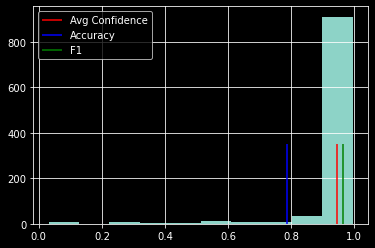

In [ ]:
import matplotlib.pyplot as plt
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

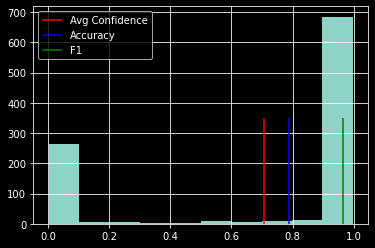

In [ ]:

data['score'].hist()
plt.vlines(x=data.score.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

### Eval on Test Set

In [7]:
prediction = apply_ged_pipeline(test_df.text.values, majority_vote=True)
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [6]:
data = test_df.copy(deep=True)
data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

data['prediction'] = prediction[0]
# pred_df = pd.read_csv('../submissions-aug/submission.csv', delimiter='\t')
# pred_df['id'] = range(1, 1+len(pred_df))
# pred_df.set_index('id', inplace=True)
# data['prediction'] = pred_df.label

data = data[['comp', 'prediction', 'text']]
print(len(data[data.comp != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data.comp != data.prediction])

400


comp  prediction  \
id                       
1        0           1   
2        0           1   
3        0           1   
8        0           1   
10       0           1   
11       0           1   
12       0           1   
18       0           1   
22       0           1   
30       0           1   
34       0           1   
36       0           1   
40       0           1   
41       0           1   
42       0           1   
44       0           1   
46       0           1   
47       0           1   
52       0           1   
54       0           1   
55       0           1   
61       0           1   
63       0           1   
64       0           1   
67       0           1   
68       0           1   
69       0           1   
70       0           1   
71       0           1   
74       0           1   
75       0           1   
77       0           1   
82       0           1   
83       0           1   
85       0           1   
86       0           1   
87       0           1   
88       0           1   
90       0           1   
93       0           1   
96       0           1   
99       0           1   
103      0           1   
107      0           1   
112      0           1   
113      0           1   
114      0           1   
117      0           1   
119      0           1   
123      0           1   
124      0           1   
125      0           1   
128      0           1   
132      0           1   
135      0           1   
137      0           1   
138      0           1   
140      0           1   
142      0           1   
145      0           1   
148      0           1   
150      0           1   
152      0           1   
154      0           1   
155      0           1   
160      0           1   
164      0           1   
169      0           1   
173      0           1   
174      0           1   
175      0           1   
177      0           1   
178      0           1   
181      0           1   
182      0           1   
184      0           1   
186      0           1   
189      0           1   
197      0           1   
198      0           1   
199      0           1   
201      0           1   
206      0           1   
208      0           1   
210      0           1   
211      0           1   
213      0           1   
214      0           1   
223      0           1   
228      0           1   
230      0           1   
232      0           1   
234      0           1   
236      0           1   
240      0           1   
242      0           1   
243      0           1   
244      0           1   
247      0           1   
252      0           1   
255      0           1   
256      0           1   
257      0           1   
260      0           1   
262      0           1   
264      0           1   
265      0           1   
266      0           1   
269      0           1   
271      0           1   
272      0           1   
275      0           1   
276      0           1   
277      0           1   
279      0           1   
282      0           1   
284      0           1   
287      0           1   
292      0           1   
295      0           1   
297      0           1   
300      0           1   
302      0           1   
307      0           1   
309      0           1   
312      0           1   
314      0           1   
320      0           1   
324      0           1   
326      0           1   
328      0           1   
331      0           1   
335      0           1   
338      0           1   
339      0           1   
340      0           1   
342      0           1   
344      0           1   
351      0           1   
352      0           1   
355      0           1   
357      0           1   
360      0           1   
363      0           1   
364      0           1   
365      0           1   
369      0           1   
371      0           1   
372      0           1   
374      0           1   
375      0           1   
382      0           1   
38

In [8]:
test_probs, test_seq_probs, test_err_char_lst = apply_ged_pipeline(test_df.text.values)
ntf()

100%|██████████| 65/65 [01:00<00:00,  1.08it/s]


In [10]:
test_data = test_df.copy(deep=True)
test_data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

test_data['prediction'] = test_probs.argmax(1)
test_data['score'] = test_probs[:, 1]
test_data['confidence'] = 1 - 2*np.abs(test_data.score.values - test_data.prediction)

test_data = test_data[['comp', 'prediction',  'score', 'confidence', 'text']]
# test_data['error_chars'] = test_err_char_lst
print(len(test_data[test_data.comp != test_data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # display(data[data.comp != data.prediction].sort_values(by='confidence'))
    display(test_data[test_data.comp != test_data.prediction])

263


comp  prediction     score  confidence  \
id                                             
8        0           1  0.532095    0.064190   
13       1           0  0.197834    0.604331   
18       0           1  0.659339    0.318678   
22       0           1  0.538983    0.077967   
25       1           0  0.243301    0.513399   
29       1           0  0.185317    0.629366   
42       0           1  0.704336    0.408671   
57       1           0  0.425843    0.148313   
58       1           0  0.388398    0.223203   
63       0           1  0.600122    0.200244   
72       1           0  0.434399    0.131201   
76       1           0  0.423113    0.153775   
83       0           1  0.690285    0.380569   
84       1           0  0.394654    0.210691   
88       0           1  0.553603    0.107207   
91       1           0  0.205744    0.588513   
95       1           0  0.200740    0.598521   
96       0           1  0.768431    0.536862   
100      1           0  0.356100    0.287800   
101      1           0  0.487307    0.025386   
115      1           0  0.318273    0.363454   
116      1           0  0.287550    0.424900   
118      1           0  0.428488    0.143024   
127      1           0  0.477820    0.044360   
131      1           0  0.470932    0.058135   
133      1           0  0.440309    0.119382   
142      0           1  0.521248    0.042495   
145      0           1  0.584007    0.168014   
154      0           1  0.624485    0.248970   
155      0           1  0.672890    0.345779   
163      1           0  0.205761    0.588478   
164      0           1  0.662004    0.324008   
165      1           0  0.247536    0.504927   
169      0           1  0.599816    0.199633   
175      0           1  0.646156    0.292312   
179      1           0  0.417771    0.164459   
183      1           0  0.316570    0.366861   
188      1           0  0.224695    0.550611   
189      0           1  0.509962    0.019924   
190      1           0  0.460660    0.078681   
191      1           0  0.231269    0.537461   
193      1           0  0.202179    0.595643   
194      1           0  0.323603    0.352794   
195      1           0  0.352089    0.295822   
204      1           0  0.371068    0.257864   
207      1           0  0.322185    0.355631   
210      0           1  0.511939    0.023877   
211      0           1  0.509352    0.018704   
215      1           0  0.492781    0.014438   
217      1           0  0.456324    0.087353   
218      1           0  0.278272    0.443456   
219      1           0  0.466085    0.067830   
221      1           0  0.474541    0.050918   
224      1           0  0.482751    0.034497   
231      1           0  0.435933    0.128134   
233      1           0  0.229361    0.541278   
239      1           0  0.207320    0.585360   
242      0           1  0.594803    0.189606   
248      1           0  0.291736    0.416527   
256      0           1  0.807273    0.614546   
259      1           0  0.361828    0.276344   
267      1           0  0.451724    0.096551   
274      1           0  0.491658    0.016684   
277      0           1  0.639833    0.279667   
278      1           0  0.305037    0.389925   
285      1           0  0.485010    0.029980   
287      0           1  0.656263    0.312527   
289      1           0  0.376612    0.246777   
296      1           0  0.234496    0.531007   
298      1           0  0.171768    0.656464   
304      1           0  0.464837    0.070326   
309      0           1  0.529687    0.059373   
314      0           1  0.612834    0.225668   
319      1           0  0.446756    0.106488   
321      1           0  0.065089    0.869822   
322      1           0  0.314751    0.370499   
324      0           1  0.807955    0.615910   
329      1           0  0.369654    0.260692   
337      1           0  0.457612    0.084775   
344      0           1  0.668272    0.336543   
346      1           0  0.305239    0.389521   
349      1           0

In [11]:
test_data = test_df.copy(deep=True)
test_data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

test_data['prediction'] = pd.read_csv('../submissions/submission.csv', delimiter='\t').set_index('id').label
test_data = test_data[['comp', 'prediction', 'text']]
print(len(test_data[test_data.comp != test_data.prediction]))
full_display(test_data[test_data.comp != test_data.prediction])

227


comp  prediction  \
id                       
13       1           0   
22       0           1   
25       1           0   
29       1           0   
42       0           1   
57       1           0   
58       1           0   
72       1           0   
76       1           0   
78       1           0   
83       0           1   
88       0           1   
91       1           0   
95       1           0   
96       0           1   
101      1           0   
116      1           0   
118      1           0   
122      1           0   
124      0           1   
127      1           0   
133      1           0   
136      1           0   
156      1           0   
163      1           0   
164      0           1   
165      1           0   
169      0           1   
175      0           1   
183      1           0   
188      1           0   
190      1           0   
191      1           0   
193      1           0   
194      1           0   
195      1           0   
196      1           0   
197      0           1   
202      1           0   
207      1           0   
210      0           1   
218      1           0   
219      1           0   
221      1           0   
231      1           0   
233      1           0   
237      1           0   
239      1           0   
241      1           0   
242      0           1   
248      1           0   
251      1           0   
256      0           1   
258      1           0   
259      1           0   
263      1           0   
267      1           0   
269      0           1   
274      1           0   
277      0           1   
278      1           0   
285      1           0   
287      0           1   
289      1           0   
296      1           0   
300      0           1   
301      1           0   
304      1           0   
314      0           1   
318      1           0   
319      1           0   
321      1           0   
322      1           0   
324      0           1   
329      1           0   
337      1           0   
344      0           1   
346      1           0   
347      1           0   
355      0           1   
359      1           0   
366      1           0   
368      1           0   
373      1           0   
377      1           0   
379      1           0   
392      1           0   
395      1           0   
398      1           0   
404      0           1   
412      1           0   
413      0           1   
415      1           0   
422      1           0   
425      1           0   
427      1           0   
434      0           1   
438      1           0   
443      1           0   
446      1           0   
448      0           1   
450      0           1   
452      0           1   
467      1           0   
468      1           0   
469      1           0   
470      1           0   
471      1           0   
474      1           0   
477      1           0   
480      1           0   
494      0           1   
495      1           0   
499      1           0   
500      1           0   
525      1           0   
526      1           0   
532      1           0   
533      1           0   
538      1           0   
550      1           0   
551      1           0   
552      1           0   
556      1           0   
559      0           1   
563      1           0   
564      1           0   
570      1           0   
577      1           0   
579      0           1   
594      1           0   
597      1           0   
610      1           0   
615      1           0   
623      1           0   
635      1           0   
638      1           0   
641      1           0   
646      1           0   
648      1           0   
653      1           0   
656      0           1   
659      1           0   
668      1           0   
670      1           0   
671      1           0   
681      0           1   
694      1           0   
700      0           1   
702      1           0   
709      1           0   
713      0           1   
71

In [64]:
len(test_data[(test_data.comp != test_data.prediction) & (test_data.comp == 0)]), \
    len(test_data[(test_data.comp != test_data.prediction) & (test_data.comp == 1)])

(61, 128)

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.options.display.max_colwidth = 100
    display(test_data)

comp  prediction     score  confidence  \
id                                             
1        0           0  0.111162    0.777675   
2        0           0  0.447806    0.104387   
3        0           0  0.129321    0.741358   
4        1           1  0.865235    0.730470   
5        1           1  0.936350    0.872699   
6        1           1  0.983011    0.966021   
7        1           1  0.972499    0.944997   
8        0           0  0.137999    0.724002   
9        1           1  0.547080    0.094160   
10       0           0  0.412745    0.174510   
11       0           1  0.633666    0.267333   
12       0           0  0.237306    0.525387   
13       1           0  0.173600    0.652800   
14       1           1  0.976061    0.952122   
15       1           1  0.983110    0.966219   
16       1           1  0.997051    0.994101   
17       1           1  0.985173    0.970345   
18       0           0  0.075467    0.849066   
19       1           1  0.986585    0.973171   
20       1           1  0.988008    0.976017   
21       1           1  0.925988    0.851977   
22       0           1  0.805537    0.611075   
23       1           1  0.982820    0.965640   
24       1           1  0.816120    0.632241   
25       1           0  0.245598    0.508804   
26       1           1  0.926356    0.852711   
27       1           1  0.895529    0.791058   
28       1           1  0.506044    0.012089   
29       1           0  0.054624    0.890752   
30       0           0  0.060177    0.879645   
31       1           1  0.984940    0.969880   
32       1           1  0.893740    0.787479   
33       1           1  0.954279    0.908559   
34       0           0  0.072282    0.855435   
35       1           1  0.973160    0.946320   
36       0           0  0.160273    0.679453   
37       1           1  0.986202    0.972404   
38       1           0  0.396032    0.207936   
39       1           1  0.692742    0.385484   
40       0           0  0.299476    0.401048   
41       0           0  0.094184    0.811632   
42       0           1  0.758895    0.517790   
43       1           1  0.959108    0.918216   
44       0           0  0.146132    0.707735   
45       1           1  0.710003    0.420006   
46       0           0  0.149543    0.700913   
47       0           0  0.258862    0.482275   
48       1           1  0.952598    0.905195   
49       1           1  0.969196    0.938392   
50       1           1  0.935502    0.871005   
51       1           1  0.984925    0.969851   
52       0           0  0.029776    0.940449   
53       1           1  0.641320    0.282641   
54       0           0  0.063428    0.873144   
55       0           0  0.143570    0.712860   
56       1           1  0.978502    0.957004   
57       1           0  0.329366    0.341268   
58       1           0  0.257189    0.485623   
59       1           1  0.993937    0.987874   
60       1           1  0.986921    0.973842   
61       0           0  0.093034    0.813932   
62       1           1  0.577968    0.155937   
63       0           0  0.191621    0.616758   
64       0           0  0.302921    0.394157   
65       1           0  0.371716    0.256567   
66       1           1  0.992050    0.984101   
67       0           0  0.141107    0.717786   
68       0           0  0.232655    0.534690   
69       0           0  0.133206    0.733588   
70       0           0  0.195718    0.608564   
71       0           0  0.135169    0.729662   
72       1           0  0.466852    0.066296   
73       1           1  0.829029    0.658058   
74       0           0  0.075790    0.848421   
75       0           0  0.126324    0.747352   
76       1           0  0.352366    0.295267   
77       0           0  0.357862    0.284275   
78       1           0  0.280234    0.439532   
79       1           1  0.916775    0.833549   
80       1           0  0.479225    0.041549   
81       1           1  0.988410    0.976820   
82       0           0

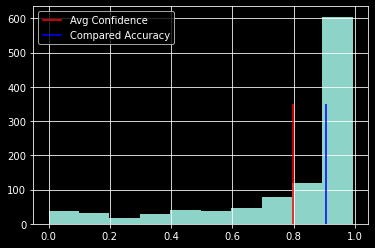

In [124]:
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=len(data[data.comp == data.prediction]) / len(data), ymin=0, ymax=350, colors='blue', label='Compared Accuracy')
# plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

In [5]:
submissions = data[['prediction']].rename(columns={'prediction':'label'})
submissions['id'] = range(1, 1+len(submissions))
submissions = submissions[['id', 'label']]
submissions.to_csv('../submissions-aug/submission-da.csv', index=False, sep='\t')

# Loss

In [9]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch, focal_loss=True):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output['logits'], axis=-1)
        if focal_loss:
            loss = binary_focal_loss(output['logits'], batch["labels"].to(device), alpha=0.3, gamma=0.8, sum=False)
        else:
            loss = cross_entropy(output['logits'], batch["labels"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
# model = BertWithNER(bert_model=model_name, ner_model=ner_model_name)
model = AutoModelWithNER(model=model_name, ner_model=ner_model_name)
state_dict = torch.load(checkpoints[0], map_location=device)
# for key in list(state_dict.keys()):
#     state_dict[key.replace('bert', 'base_model')] = state_dict.pop(key)
model.load_state_dict(state_dict)
model.cuda()

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at uer/roberta-base-finetuned-cluener2020-chinese were not used when initializi

AutoModelWithNER(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [10]:
train.dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'auxiliary_input_ids', 'labels'])
eval_outputs = train.dataset['val'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/283 [00:00<?, ?ba/s]

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display()

label                                               text
id                                                               
23495-1      1  海南“国际旅游岛”项目是我国由官方独立建造、独立规划、独立投资、独立管理、独立收支的特大型海...
39138        1                    央视“成语大会”栏目将国学娱乐化，有利于更多人研究和了解国学。
20777        1  随着反腐力度的进一步加大，新的反腐形势也在出现，有的甚至更加隐秘。反腐是一场持久的战争，它的...
30283        1  “汕优63”杂交稻近几年的年种植面积都超过1亿亩，平均亩产稳定在约500千克左右，不仅产量高...
34053        1  通过这几年的努力，使中国的水面舰艇研制水平和研制能力已经进入世界先进行列，这为中国海军执行远...
41533        1  在此次重庆市青少年科技创新大赛中，同学们常围在一起相互鼓劲并认真总结得失，赢得的远远不只是比...
15549        1         价格改革涉及利益复杂，不仅要坚持改革的方向，积极推进，而且要对方案认真周密研究部署。
42976        1      南通老百姓和海内外游客在狼山不仅可以感受到江海神韵，还可以感受到民族文化的永恒魅力之所在。
11432        1  据美国务院发言人维多利亚·纽兰9日在例行新闻发布会上表示，希望中国发挥影响力，采取措施帮助阻...
14855        1  2010年12月15日，海尔发布一款新型手机，这是一款待机功能十分突出的商务型手机，内置智能...
25522        0  出口退税增量实行中央和地方分担，是否会出现新的欠税和退税现象以及跨地区收购、出口贸易受限等问...
16300        1  我国在2010年里再次出台促进农业发展的一系列激励政策、调控政策和财政政策，极大地激发和调动...
14805        1        为解决“最后一公里”的问题，不少快递公司进行了自建门店、合作便利店、智能快递柜等方式。
39598        0  无论是提高艺术表现力，还是判断艺术的优劣高下和学术上的是非，都不靠行政命令，而要靠艰苦的艺术...
11108        0                         语文课程是一门学习语言文字运用的综合性、实践性课程。
25018        1  截至27日，利比亚反对派已经控制的黎波里绝大部分区域，但双方的战斗仍在南部市郊持续胶着。虽然...
35227        1  近日多个自媒体微信公众号发布了“缩短学制”的报道，该消息在家长群中被广泛转发传播，对此，省教...
13091        0              4月10日，铁路部门开始在全国实施新的列车运行方案，优化高铁列车开行路线。
38409        1            在新形势下，我们应该树立新的文化发展观，挖掘和推进文化体制创新和特色文化内涵。
12749        1  钱培芝提醒公众，不要轻信那些不负责任的宣传，也不要迷信巧舌如簧的推销诱惑，同时重视自我保护，...
40802        1  留学生们如果能为自己找准清晰的定位，为自己而留学，那么社会上“留学归国后找不到工作”的抱怨，...
24947        0                国务院要求加快推进宽带网络基础设施建设，进一步提速降费，提高服务水平。
28414        1   欧洲正面临十年来最严重的恐怖威胁，反恐任务十分艰巨，还需要进一步加快建立信息共享并加强情报分析。
29454        0                      为了防止此类事故再发生，本市相关部门采取了一系列安全措施。
24141        0  中东局势依然动荡，原油价格大幅上升，将对全球经济复苏产生不利影响，美国经济复苏的前景也因此蒙...
2680         1  很多同学都深切地说，自己体会到了鲁迅为了拯救国民灵魂而不惜呐喊、勇往直前的奋斗精神，以及他胸...
1066         0  学习绘画的人们都应该知道，孩子在先期学习的时候主要就是临摹，而几米的作品构图简单，线条和色彩...
12083        1  考古专家认为，山东兖州兴隆塔地宫的发掘，对古代佛教文化研究不仅有重大贡献，并且具有极高的历史...
16593        0                              通过这次活动，我们开阔了眼界，增长了知识。
3157         1           该书的出版把“名人”出书热又掀起一个高潮，同时也引来对名人出书热的更严厉的批评。
42884        0  桐城派的义法是应封建社会的政治需要而产生的，随着封建社会的逐步解体，打破桐城派义法的枷锁成为...
41437        1                      《朗读者》得到广泛好评，是因为其形式新颖、内涵丰富的缘故。
26084        1  由于存款准备金率上调，使得银行必须调整资产的配置，将资金从债券、贷款等高收益品种调整至准备金...
31929        0                               大气污染影响了农作物的播种、培育和收获。
15560        1  为进一步保障百姓餐桌安全，国家对施行已超过5年的《食品安全法》做了修订，因加大了惩处力度而被...
43020        1  有人认为在语文课堂上让学生读读武侠小说，能激发学生的阅读兴趣；也有人担心，将这些与法治精神背...
31417        1  央视请来教育部部长周济，请他就当前备受指责的高考阐述官方立场。周部长坦承民众所指出的当前高中...
41531        1  经济危机爆发之后，希腊政府面临的最大困境是如何解决失业问题，严峻的形势将巨大的挑战带给了希腊...
39273        1        天地境界又可以叫做哲学境界，因为如果通过哲学，获得对宇宙的某些了解，就能达到天地境界。
18414        0        对以中国为主的对美顺差大国而言，适当的妥协不可避免，但讨价还价和适度的斗争则是必须的。
21596        0  “才”固然重要，但如果没有一颗奉献于国家，为人民谋取福祉的心，你即使学富五车、满腹经纶，也不...
33742        0  我省出版界积极组织精品图书参展，介绍、展现本省出版界面对加入WTO的新形势，加快产业化发展的...
38394        1  11月1日，俄罗斯、伊朗和阿塞拜疆三国总统在德黑兰会面，商谈的内容之一就是加速沿里海的连通三...
6230         1        在央视的文化栏目《国家宝藏》中，通过明星守护人的讲述，使观众看到了国宝的“前世今生”。
24246        0  著名导演英达持美国绿卡，这意味着他在世界各地的收入都需要向美国国税局报税纳税，他不愿意这么做...
22848        1  华罗庚这个名字，对我国广大的学术界朋友以及青少年是非常熟悉的。他是世界第一流的数学家，他的成...
2785         0            文章在讲述每个小故事的前后常有些议论，这些议论是为了抒发作者对鲁迅的热爱之情。
43399        1             昨天有三个报社的记者来到了石家庄一中，对老师们和同学们进行了为期一天的采访。
28835        1              据报道，2019年我国新减降费超过2万亿元左右，与GDP比重超过2%左右。
17625        1                        我们要努力克服这种费力不讨好的学习方法，提高学习成绩。
18307        1  武汉邮电科学研究院近日完成超大容量光传输实验，其传输量是单模光纤最大传输量的5倍，可满足一根...
1127         1                 2010年我省大学招收的本科自费生，是自恢复高考制度以来最多的一年。
22890        0  各国政府都驱逐他，资产者都竞相诽谤他诅咒他。他对这一切毫不在意，把它们当作蛛丝一样轻轻拂去，...
1459         1  博士教育一旦以满足社会对“具有博士学位人才”的需要为目的，就必然会走向规模迅速扩大而质量急剧下滑。
32056        1   中国教育工作者对位于巴黎市中心塞纳河畔的“国立蓬皮杜文化艺术中心”的公共图书馆留下了深刻的印象。
28653        1        冬天的乌镇应该是旅游的淡季，但因为第二届互联网大会的召开，这座江南小镇变得热闹起来了。
20348        1  据审计署发布的最新数据显示，大多数领导干部能够执行中央决策部署，认真履行职责，但也有个别领导...
15086        1  中国共产党建党九十周年的庆祝活动，大大激发了全国人民炽烈的爱国热情和民族精神，为全面建设小康...
40994        1                    老头儿觉得嘴里有一股奇怪的味道